# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a model's existing architecture and learned patterns for our own projects.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to to our own, then we can adapt those patterns to our own data.

In [1]:
!nvidia-smi

Sun Jan  8 02:45:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.65       Driver Version: 527.56       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:04:00.0  On |                  N/A |
|  0%   50C    P8    40W / 350W |    733MiB / 24576MiB |     12%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [2]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
    
# unzip
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-01-08 02:45:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.116.128, 142.251.32.144, 142.251.33.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.116.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  99.0MB/s    in 1.6s    

2023-01-08 02:45:51 (99.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



> Need to move the folder into the data folder manually and delete the extraneous zip folder.

In [3]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

2023-01-08 02:45:52.565143: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 02:45:53.296467: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2023-01-08 02:45:53.296519: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2023-01-08 02:45:53.298623: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2023-01-08 02:45:53.587094: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.


In [4]:
# How many images in each folder
import os

# walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("../data/10_food_classes_10_percent"):
    print(f"There are {len(filenames)} directories and {len(filenames)} images in '{dirpath}'")

There are 0 directories and 0 images in '../data/10_food_classes_10_percent'
There are 0 directories and 0 images in '../data/10_food_classes_10_percent/test'
There are 250 directories and 250 images in '../data/10_food_classes_10_percent/test/fried_rice'
There are 250 directories and 250 images in '../data/10_food_classes_10_percent/test/chicken_curry'
There are 250 directories and 250 images in '../data/10_food_classes_10_percent/test/grilled_salmon'
There are 250 directories and 250 images in '../data/10_food_classes_10_percent/test/chicken_wings'
There are 250 directories and 250 images in '../data/10_food_classes_10_percent/test/hamburger'
There are 250 directories and 250 images in '../data/10_food_classes_10_percent/test/ramen'
There are 250 directories and 250 images in '../data/10_food_classes_10_percent/test/sushi'
There are 250 directories and 250 images in '../data/10_food_classes_10_percent/test/ice_cream'
There are 250 directories and 250 images in '../data/10_food_classe

> Same amount of test data, however, training data has been reduced to 10%, or 75 images per class across the 10 classes.

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches

In [5]:
# Set up data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = "../data/10_food_classes_10_percent/train/"
test_dir = "../data/10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Images: ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                         target_size=IMG_SHAPE,
                                                         batch_size=BATCH_SIZE,
                                                         class_mode="categorical")

print("Testing Images: ")
test_data = test_datagen.flow_from_directory(test_dir,
                                            target_size=IMG_SHAPE,
                                            batch_size=BATCH_SIZE,
                                            class_mode='categorical')

Training Images: 
Found 750 images belonging to 10 classes.
Testing Images: 
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run while model is training)

Callbacks are extra functionality you can add to your models to be performed during or after training.

Some popular callbacks:
* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with EarlyStopping callback

In [6]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    
    print(f"Saving TensorBoard log files to: {log_dir}")
    
    return tensorboard_callback

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Model 1: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1 <br>
Model 2: https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5

In [7]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [8]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
    """
    Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
    
    Args:
        model_url (str): A TensorFlow Hub feature extraction URL.
        num_classes (int): Number of output neurons in the output layer,
            should be equal to the number of target classes, default 10.
            
    Returns:
        An uncompiled Keras Sequential model with model_url as feature extractor 
        layer and Dense output layer with num_classes output neurons.
    """
    # Download the pretrained model and save it as a keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                            trainable=False, # Freeze the already learned patterns, keep og model coefficients
                                            name="feature_extraction_layer",
                                            input_shape=IMG_SHAPE + (3,)) # appends the depth dimension to the IMG_SHAPE global
    
    # Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation="softmax")
    ])
    
    return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction Model

In [9]:
# Create resnet model
resnet_model = create_model(resnet_url,
                           num_classes=train_data_10_percent.num_classes)

2023-01-08 02:45:54.359275: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 02:45:54.360465: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (NVIDIA GeForce RTX 3090)
2023-01-08 02:45:54.482504: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-08 02:45:54.482534: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:28] Overriding allow_growth setting because force_memory_growth was requested by the device.
2023-01-08 02:45:54.482551: I tensorflow/core/common_runtime/pluggable_device/

In [10]:
# ResNet summary
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [11]:
# compile a model
resnet_model.compile(loss="categorical_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])

In [12]:
# fit the model
history_resnet = resnet_model.fit(train_data_10_percent,
                batch_size=BATCH_SIZE,
                epochs=5,
                steps_per_epoch=len(train_data_10_percent),
                validation_data=test_data,
                validation_steps=len(test_data),
                callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                      experiment_name="resnetV250")])

Saving TensorBoard log files to: tensorflow_hub/resnetV250/20230108-024556
Epoch 1/5


2023-01-08 02:45:57.878530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-08 02:45:58.159194: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-08 02:45:58.159241: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 83006 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2023-01-08 02:45:58.159284: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


24/24 [==============================] - ETA: 0s - loss: 2.0068 - accuracy: 0.3267

2023-01-08 02:46:05.599144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-08 02:46:05.837819: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-08 02:46:05.837868: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 83006 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2023-01-08 02:46:05.837914: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


24/24 [==============================] - 17s 551ms/step - loss: 2.0068 - accuracy: 0.3267 - val_loss: 1.3283 - val_accuracy: 0.5796
Epoch 2/5
24/24 [==============================] - 9s 369ms/step - loss: 0.9278 - accuracy: 0.7387 - val_loss: 0.8913 - val_accuracy: 0.7116
Epoch 3/5
24/24 [==============================] - 9s 373ms/step - loss: 0.6188 - accuracy: 0.8307 - val_loss: 0.7791 - val_accuracy: 0.7432
Epoch 4/5
24/24 [==============================] - 9s 369ms/step - loss: 0.4675 - accuracy: 0.8933 - val_loss: 0.7077 - val_accuracy: 0.7720
Epoch 5/5
24/24 [==============================] - 9s 370ms/step - loss: 0.3759 - accuracy: 0.9147 - val_loss: 0.6682 - val_accuracy: 0.7828


In [13]:
# create function for loss curves
import matplotlib.pyplot as plt

# plot validation and training curves
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validtion metrics.
    
    Args:
        history: TensorFlow History object
        
    Returns:
        Plots of training/validation loss and accuracy metrics.
        
    NOTE: Only accuracy will work with this function.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    epochs = range(len(history.history['loss']))
    
    # plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

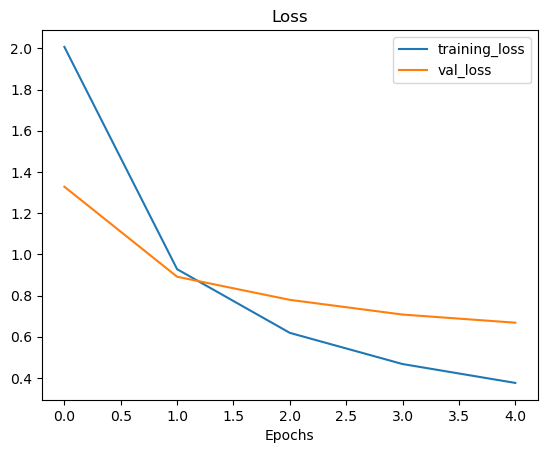

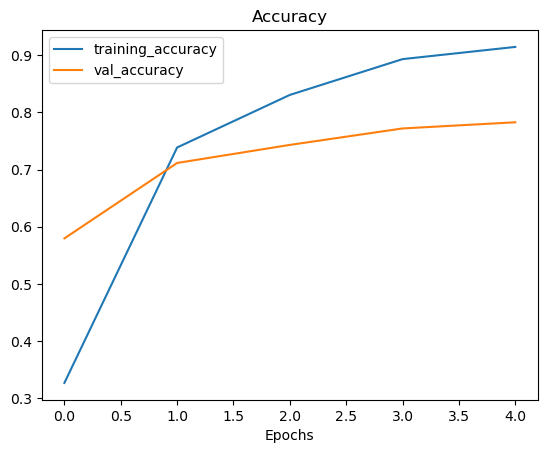

In [14]:
plot_loss_curves(history_resnet)

In [15]:
# Create EfficientNetB0 feature extractor model
efficientnet_model = create_model(model_url=efficientnet_url,
                                 num_classes=train_data_10_percent.num_classes)

# compile
efficientnet_model.compile(loss="categorical_crossentropy",
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=["accuracy"])

# fit EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=EPOCHS,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20230108-024653
Epoch 1/5


2023-01-08 02:46:57.538425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-08 02:46:58.002048: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-08 02:46:58.002094: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 83006 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2023-01-08 02:46:58.002119: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-01-08 02:46:58.002657: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identi

24/24 [==============================] - ETA: 0s - loss: 1.8346 - accuracy: 0.4360

2023-01-08 02:47:02.498333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-08 02:47:02.853859: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-08 02:47:02.853900: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 83006 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2023-01-08 02:47:02.853924: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-01-08 02:47:02.854413: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identi

24/24 [==============================] - 16s 445ms/step - loss: 1.8346 - accuracy: 0.4360 - val_loss: 1.2687 - val_accuracy: 0.7528
Epoch 2/5
24/24 [==============================] - 9s 373ms/step - loss: 1.0384 - accuracy: 0.7880 - val_loss: 0.8505 - val_accuracy: 0.8272
Epoch 3/5
24/24 [==============================] - 9s 379ms/step - loss: 0.7507 - accuracy: 0.8253 - val_loss: 0.6853 - val_accuracy: 0.8464
Epoch 4/5
24/24 [==============================] - 9s 377ms/step - loss: 0.6059 - accuracy: 0.8640 - val_loss: 0.6041 - val_accuracy: 0.8532
Epoch 5/5
24/24 [==============================] - 9s 376ms/step - loss: 0.5121 - accuracy: 0.8893 - val_loss: 0.5505 - val_accuracy: 0.8632


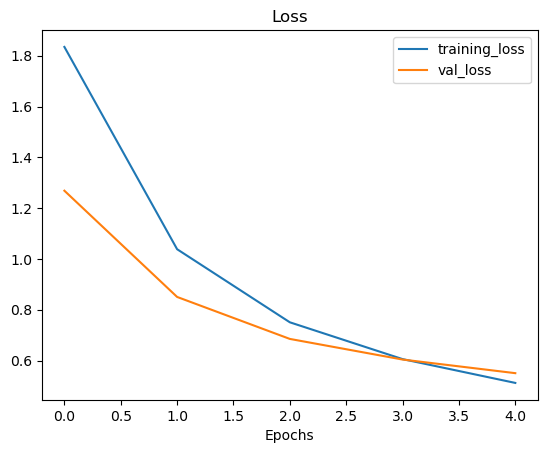

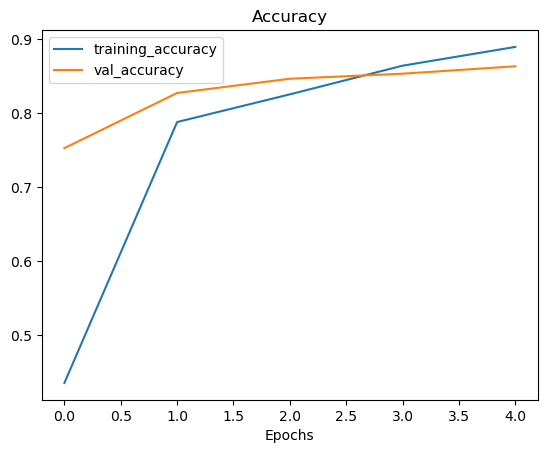

In [16]:
plot_loss_curves(efficientnet_history)

In [17]:
# params for efficientnet
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 dense_1 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [18]:
# resnet summary
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [19]:
# 309 layers for EfficientNetB0
len(efficientnet_model.layers[0].weights)

309

> EfficientNetB0 is 1/6th the params with a ~10% increased accuracy.

## Different types of tranfer learning
* '**As is**' - use an existing model in it's current state
* '**Feature extraction**' - Use prelearned patterns of an existing model and then adjust the output layer to match your own problem
* '**Fine tuning**' - Use the prelearned patterns of an existing model and tune both original layers and output layers

## Comparing our models results with TensorBoard

> **NOTE**: When you upload things to TensorBoard.dev, your experiments are public. If you're working on proprietary work, don't push them to .dev

In [20]:
%connect_info

{
  "shell_port": 43771,
  "iopub_port": 54293,
  "stdin_port": 35891,
  "control_port": 56485,
  "hb_port": 38407,
  "ip": "127.0.0.1",
  "key": "3fbef638-c3b2b815fde3e6b1d36aee3a",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-49fdc5bd-5c43-4087-b69c-dd31c22708b5.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [ ]:
# Uploading to TensorFlow Hub dev for public viewing: https://tensorboard.dev/experiment/M9gVmc2BQjagUA0sWFzEwA/
!tensorboard dev upload --logdir ./tensorflow_hub/ \
    --name "EfficientNetB0 vs ResNet50V2" \
    --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
    --one_shot

In [23]:
# Check out TensorBoard experiments you have
!tensorboard dev list

2023-01-08 03:03:18.902351: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 03:03:19.615542: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2023-01-08 03:03:19.615594: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2023-01-08 03:03:19.618067: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2023-01-08 03:03:19.912598: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.
https://tensorboard.dev/experiment/M9gVmc2BQjagUA0sWFzEwA/
	Name                 EfficientNetB0 vs ResNet50V2
	Description          Comparing two different TF Hu

In [24]:
# Delete experiment
# !tensorboard dev delete --experiment_id <experiment_id>